In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
tqdm.pandas()


from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

import time
from xgboost import XGBClassifier
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper")

/home/rafael/anaconda3/envs/penidoEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
submission = pd.read_csv('data/sample_submission.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
original = pd.read_csv("horse.csv")

df = train.copy()
target = 'defects'

In [3]:
train.head(15)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False
5,5,23.0,4.0,4.0,3.0,69.0,338.21,0.07,14.15,22.81,...,17,1,2,0,16.0,10.0,40.0,19.0,7.0,False
6,6,24.0,4.0,1.0,4.0,60.0,294.41,0.08,12.46,24.62,...,19,0,3,0,14.0,13.0,40.0,23.0,7.0,False
7,7,14.0,1.0,1.0,1.0,49.0,221.65,0.18,5.47,46.06,...,11,0,2,0,7.0,18.0,26.0,23.0,1.0,False
8,8,34.0,10.0,1.0,4.0,122.0,684.98,0.07,14.33,43.43,...,29,1,3,0,16.0,29.0,75.0,47.0,19.0,False
9,9,9.0,2.0,1.0,2.0,16.0,55.35,0.11,9.00,6.15,...,4,0,2,0,9.0,2.0,12.0,4.0,3.0,False


In [4]:
# Unique value counts for each column
unique_counts = df.nunique()

# Threshold to distinguish continuous and categorical
threshold = 10

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'outcome' from categorical since it's our target variable
categorical_vars.remove(target)
continuous_vars.remove('id')

In [5]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):

    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [6]:
summary(train).style.background_gradient(cmap='Blues')

data shape: (101763, 23)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.000000,101763,0.000000,101762.000000,50881.000000,29376.592059,0,1,2
loc,float64,0,0.000000,378,1.000000,3442.000000,37.347160,54.600401,22.000000,14.000000,11.000000
v(g),float64,0,0.000000,106,1.000000,404.000000,5.492684,7.900855,3.000000,2.000000,2.000000
ev(g),float64,0,0.000000,71,1.000000,165.000000,2.845022,4.631262,1.000000,1.000000,1.000000
iv(g),float64,0,0.000000,84,1.000000,402.000000,3.498826,5.534541,2.000000,2.000000,2.000000
n,float64,0,0.000000,836,0.000000,8441.000000,96.655995,171.147191,60.000000,32.000000,45.000000
v,float64,0,0.000000,4515,0.000000,80843.080000,538.280956,1270.791601,278.630000,151.270000,197.650000
l,float64,0,0.000000,55,0.000000,1.000000,0.111634,0.100096,0.060000,0.140000,0.110000
d,float64,0,0.000000,3360,0.000000,418.200000,13.681881,14.121306,19.560000,7.000000,8.050000
i,float64,0,0.000000,5171,0.000000,569.780000,27.573007,22.856742,14.250000,21.110000,22.760000


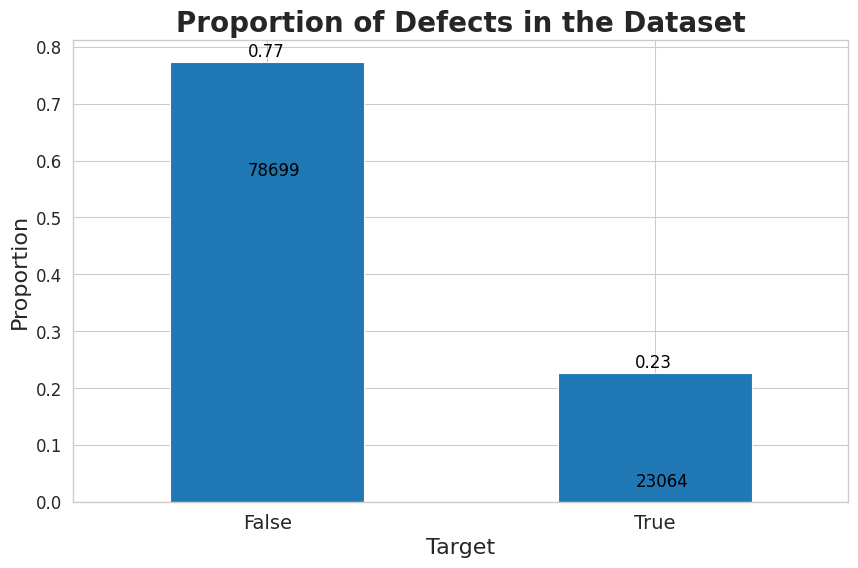

In [7]:
target_counts = df[target].value_counts(normalize=True)

ax = target_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Target', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_title('Proportion of Defects in the Dataset', fontsize=20, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0, fontsize=14)
plt.yticks(fontsize=12)

for i, v in enumerate(target_counts):
    ax.text(i-0.05, v + 0.01, f'{v:.2f}', fontsize=12, color='black')
    ax.text(i-0.05, v - 0.2, f'{v * df.shape[0]:.0f}', fontsize=12, color='black')


plt.show()

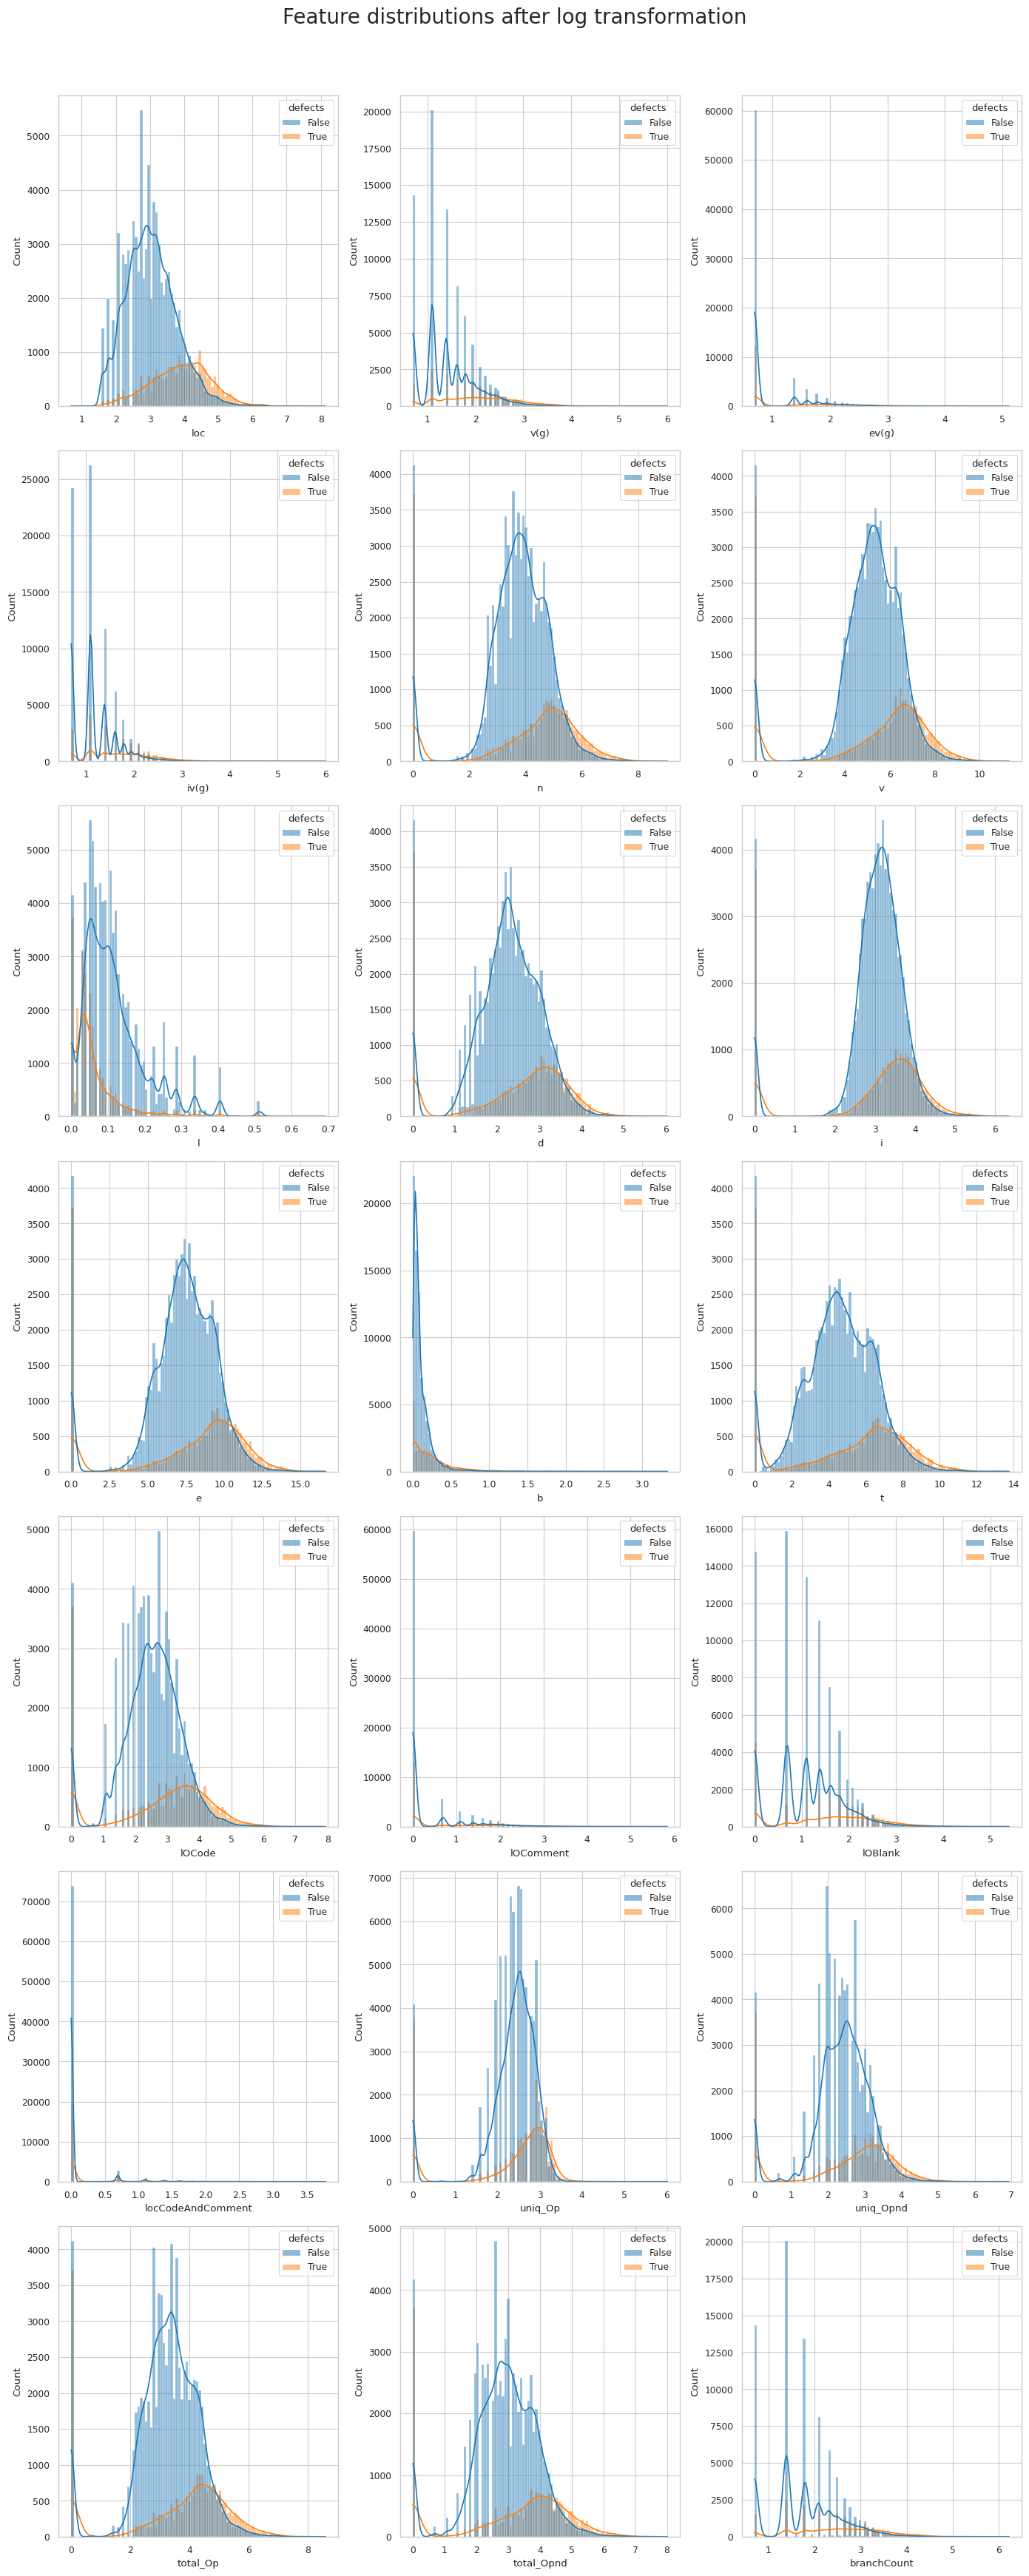

In [8]:
df_eda = df.copy()

for col in continuous_vars:
    df_eda[col] = df_eda[col].apply(lambda x: np.log(x+1))

plt.figure(figsize=(14, len(continuous_vars)*2.5))

for idx, column in enumerate(continuous_vars):
    plt.subplot(len(continuous_vars)//2 + len(continuous_vars)%2, 3, idx+1)
    sns.histplot(x=column, hue="defects", data=df_eda, bins=100, kde=True)

plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

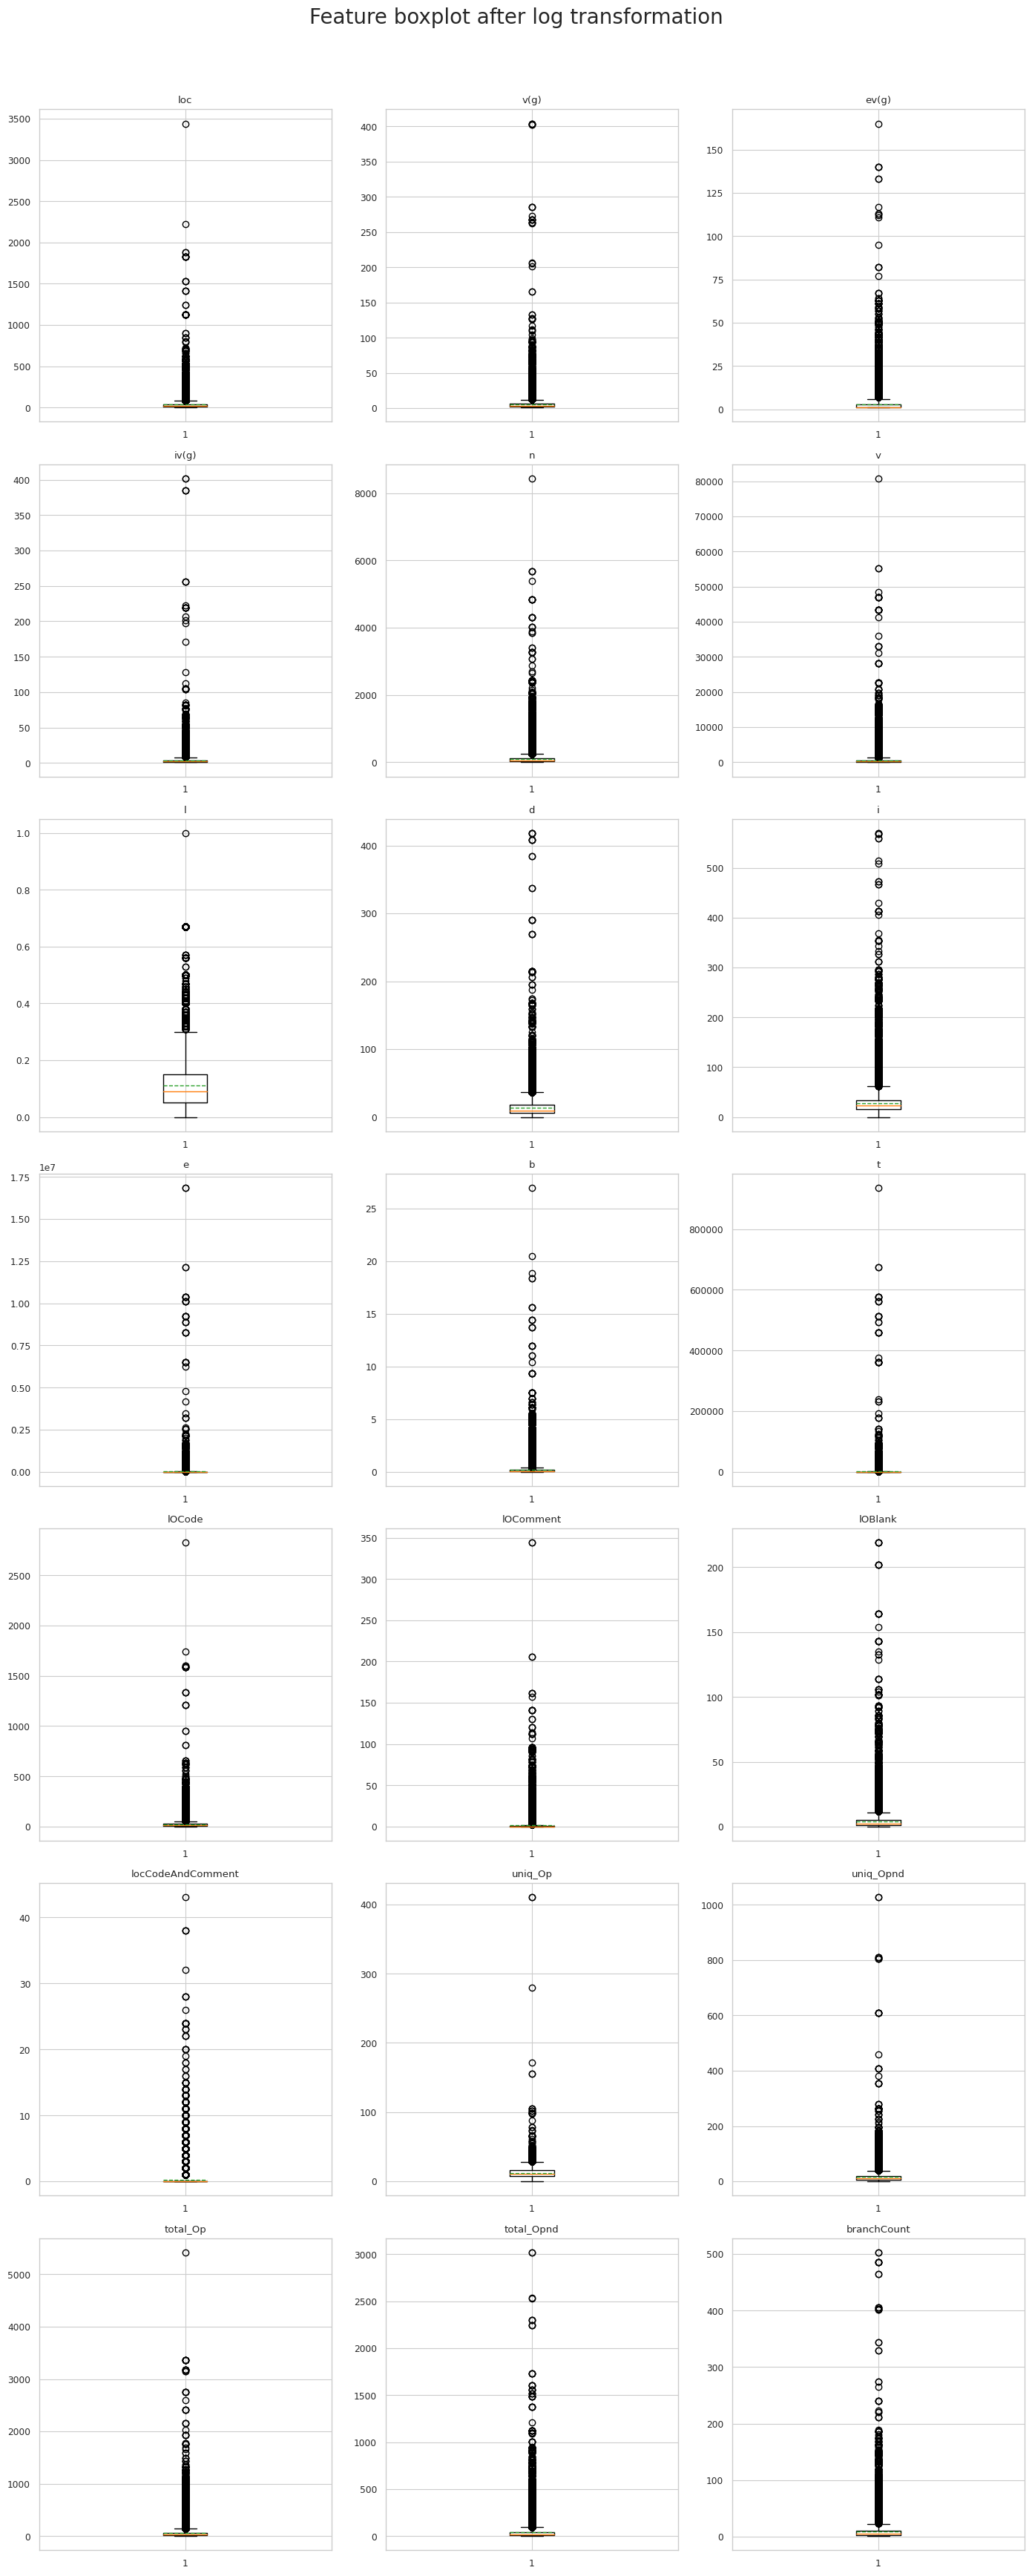

In [9]:
plt.figure(figsize=(14, len(continuous_vars)*2.5))

for idx, column in enumerate(continuous_vars):
    plt.subplot(len(continuous_vars)//2 + len(continuous_vars)%2, 3, idx+1)
    plt.boxplot(x=df[column], showmeans=True, meanline=True)
    plt.title(column)

plt.tight_layout()
plt.suptitle('Feature boxplot after log transformation', y=1.02, fontsize=20)
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score

def eval_model(model, features, target, scoring='roc_auc', folds=9):
    
    cv_scores = cross_val_score(model,features,target,scoring=scoring,cv=folds)
    scores = np.mean(cv_scores)
    
    return scores

In [11]:
def process_data(df):

    # Drop id column
    df.drop('id', axis=1, inplace=True)

    # Log transform
    for col in continuous_vars:
        df[col] = df[col].apply(lambda x: np.log(x+1))

    return df

In [12]:
all_features = continuous_vars + categorical_vars

data_processed = process_data(df)

X = data_processed[all_features]
y = data_processed[target]

In [13]:
from xgboost import XGBClassifier

xgb_md = XGBClassifier(objective='binary:logistic', eval_metric='auc')
xgb_md.fit(X, y)

X_test = process_data(test)
submission['defects'] = xgb_md.predict_proba(test)[:, 1]
submission.to_csv('submissions/base_line_submission.csv', index=False)

In [21]:
eval_model(xgb_md, X, y)

0.7853376054587943